In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from implementations import *
from helpers import *
%load_ext autoreload
%autoreload 2

# Load the training data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv'
DATA_TEST_PATH = '../data/test.csv' 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

df= pd.read_csv(DATA_TRAIN_PATH)
df.head()

,Id,Prediction,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,100000,s,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,...,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497
1,100001,b,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,...,-1.916,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226
2,100002,b,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,...,-2.186,260.414,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251
3,100003,b,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,...,0.060,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000
4,100004,b,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,...,-0.871,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000


# Data Exploration and visualization

We notice that there are some rows that have -999 as a value for some columns. This mean that the corresponding particle doesn't produce a result for the corresponding column. 
For example the collision of the particle 100002 doesn't produce a DER_mass_MMC 

In [3]:
# we replace all -999's by NaN
tX = replace_data(tX,replace=-999,by=np.nan)
df.replace(-999,np.nan,inplace=True)
df.head(10)

,Id,Prediction,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,100000,s,138.470,51.655,97.827,27.980,0.910,124.711,2.666,3.064,...,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.240,-2.475,113.497
1,100001,b,160.937,68.768,103.235,48.146,NaN,NaN,NaN,3.473,...,-1.916,164.546,1,46.226,0.725,1.158,NaN,NaN,NaN,46.226
2,100002,b,NaN,162.172,125.953,35.635,NaN,NaN,NaN,3.148,...,-2.186,260.414,1,44.251,2.053,-2.028,NaN,NaN,NaN,44.251
3,100003,b,143.905,81.417,80.943,0.414,NaN,NaN,NaN,3.310,...,0.060,86.062,0,NaN,NaN,NaN,NaN,NaN,NaN,0.000
4,100004,b,175.864,16.915,134.805,16.405,NaN,NaN,NaN,3.891,...,-0.871,53.131,0,NaN,NaN,NaN,NaN,NaN,NaN,0.000
5,100005,b,89.744,13.550,59.149,116.344,2.636,284.584,-0.540,1.362,...,2.237,282.849,3,90.547,-2.412,-0.653,56.165,0.224,3.106,193.660
6,100006,s,148.754,28.862,107.782,106.130,0.733,158.359,0.113,2.941,...,-1.443,294.074,2,123.010,0.864,1.450,56.867,0.131,-2.767,179.877
7,100007,s,154.916,10.418,94.714,29.169,NaN,NaN,NaN,2.897,...,-1.761,187.299,1,30.638,-0.715,-1.724,NaN,NaN,NaN,30.638
8,100008,b,105.594,50.559,100.989,4.288,NaN,NaN,NaN,2.904,...,0.024,129.804,0,NaN,NaN,NaN,NaN,NaN,NaN,0.000
9,100009,s,128.053,88.941,69.272,193.392,NaN,NaN,NaN,1.609,...,0.845,294.741,1,167.735,-2.767,-2.514,NaN,NaN,NaN,167.735


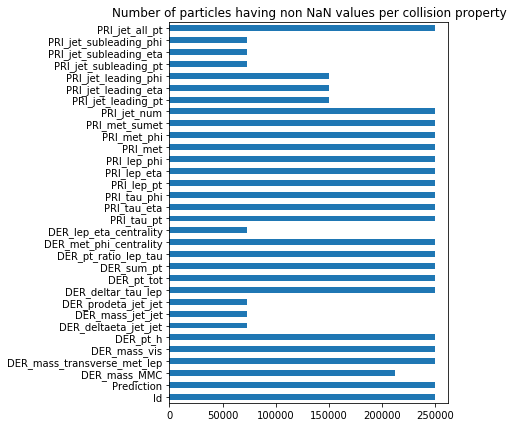

In [4]:
df.count().plot(kind='barh',title = 'Number of particles having non NaN values per collision property',figsize = (5,7))

We notice a segmentation pattern in the dataset. Since we know from the documentation of the dataset that there are 4 types of particles label according to their **PRI_jet_num** 
We thus analyze a segmentation based on that. 

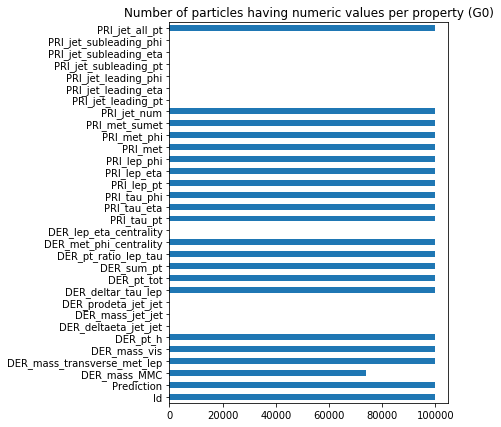

In [5]:
df[df.PRI_jet_num == 0].count().plot(kind='barh',title = 'Number of particles having numeric values per property (G0)',figsize = (5,7))

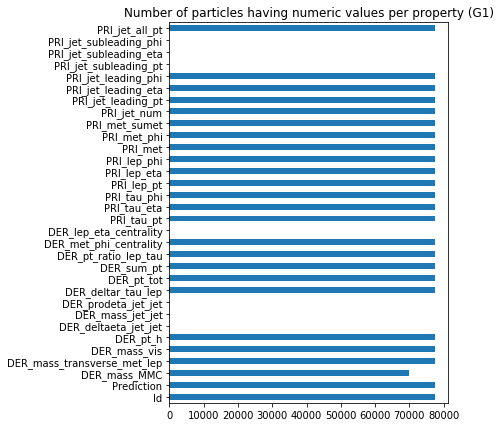

In [6]:
df[df.PRI_jet_num == 1].count().plot(kind='barh',title = 'Number of particles having numeric values per property (G1)',figsize = (5,7))

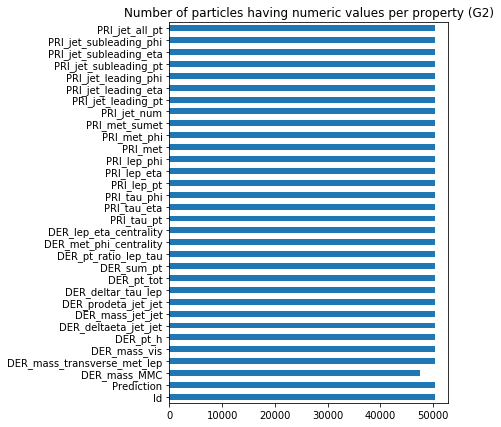

In [7]:
df[df.PRI_jet_num == 2].count().plot(kind='barh',title = 'Number of particles having numeric values per property (G2)',figsize = (5,7))

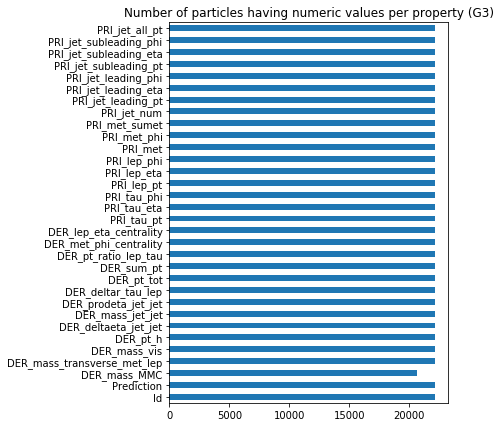

In [8]:
df[df.PRI_jet_num == 3].count().plot(kind='barh',title = 'Number of particles having numeric values per property (G3)',figsize = (5,7))

We can assert from the plots above that we should split the data according to **PRI_jet_num** into **3** groups: 

- G0 : **PRI_jet_num** = 0 
- G1 : **PRI_jet_num** = 1
- G2 : **PRI_jet_num** = 2,3 (since they both have values for all columns)

We notice also that each of the groups above have either numeric values or missing values for **DER_mass_MMC**. We thus extend our segmentation to **6** groups: 

- G0 : **PRI_jet_num** = 0 
- G0_mmc : **PRI_jet_num** = 0 and **DER_mass_MMC** != NaN
- G1 : **PRI_jet_num** = 1
- G1_mmc : **PRI_jet_num** = 1 and **DER_mass_MMC** != NaN
- G2 : **PRI_jet_num** = 2,3 
- G2_mmc : **PRI_jet_num** = 2,3 and **DER_mass_MMC** != NaN



To solve this problem and implement a good robust model we chose to adopt a **Split - Predict - Combine** strategy:

- Training : 

    - We split the dataset into six subsets
    
    - We train a prediction model for each subset
    
- Prediction: 

    - We split the testing dataset following the same pattern as in the training step.
    
    - We predict the results for each subset using the corresponding model
    
    - We combine our six prediction sets into one 
    

# Data preparation for model training

We first replace all -999 by NaN and transform the prediction values from {-1, 1} to {0, 1}

In [9]:
tX, tX_test = replace_data(tX, replace=-999, by=np.NaN), replace_data(tX_test, replace= -999, by=np.NaN)

# When using logistic regression, mapping y to [0, 1] is needed
# y = replace_data(y, -1, 0)

 Since our problem is reduced to a binary classification problem, we decided tp provide a regression based solution using the following techniques : 

- Ridge regression for avoiding overfitting

- Polynomial Feature expansion 

- Accuracy function as an evaluation metric

- Data standarization 

- Cross validation for tuning the ridge's hyperparameter 


We use an automated approach for finding the best degree for the polynomial expansion and the best hyperparameter for the overfitting avoidance by maximizing the *accuracy* of our predictions 


# Parameters initialisation and definition 

In [10]:
# The degrees to choose from for the polynomial expansion 
degrees = np.arange(2, 8)

# The hyperparameters to choose from for ridge regression 
lambdas = np.logspace(-4, 0, 20)
gamma = 0.01

# The number of splitting part for the cross validation
k_fold = 4

# initialize the maximum number of iterations for updating the weights when using gradient descent
max_iters = 1000

# Initialize the seed
seed = 30

# Get the indices of the subsets in the training and the test datasets
indices_train_group = group_indices(tX)
indices_test_group = group_indices(tX_test)

# initialize the prediction array
initial_y_pred = np.zeros(tX_test.shape[0])
y_train_pred = np.zeros(y.shape[0])

# Model training 

In [11]:
from train_ridge_regression import * 

best_weights, best_degree, best_lambda = train_models_ridge_regression(y, tX, degrees, lambdas, k_fold, seed)

Computing optimal weights and hyper parameters for the  1 th subset...
Computing optimal weights and hyper parameters for the  2 th subset...
Computing optimal weights and hyper parameters for the  3 th subset...
Computing optimal weights and hyper parameters for the  4 th subset...
Computing optimal weights and hyper parameters for the  5 th subset...
Computing optimal weights and hyper parameters for the  6 th subset...


In [12]:
best_degree

[7, 3, 5, 4, 6, 7]

In [13]:
best_lambda

[0.0001623776739188721,
 0.0001623776739188721,
 0.05455594781168514,
 0.05455594781168514,
 0.0001,
 0.0001]

In [14]:
# Accuracy information on our training data

for i, indice_train_group in enumerate(indices_train_group):
    tx_train_subset = standardize(drop_na_columns(tX[indice_train_group]))[0]
    
    y_pred_train_subset = predict_labels(best_weights[i], build_poly(tx_train_subset, best_degree[i]), False)
    y_train_pred[indice_train_group] = y_pred_train_subset

In [15]:
accuracy_train = performance_measure(y_train_pred, y)

In [16]:
accuracy_train

0.813152

# Predictions 

In [17]:
y_pred = predict(initial_y_pred, tX, tX_test, indices_test_group, indices_train_group, best_weights, best_degree, logistic=False)

In [18]:
y_pred

array([-1., -1., -1., ...,  1., -1., -1.])

# Submission

In [19]:
OUTPUT_PATH = '../data/sample-submission_ridge_regression.csv'
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

# Results

Our prediction model composed of six trained submodels allowed us to reach an overall *accuracy* of 0.813 for the testing dataset. 
